Found Blob Datastore with name: machinelearnin9764837687
Register dataset in Azure ML
Register experiment in Azure ML
Examine titanic dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     1309 non-null   int64  
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1046 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
dtypes: float64(2), int64(5), object(5)
memory usage: 122.8+ KB
Show first records
Show first records of all the features created
(538, 13) (360, 13)
(538,) (360,)

,Model
Score,
61.15,Random Forest


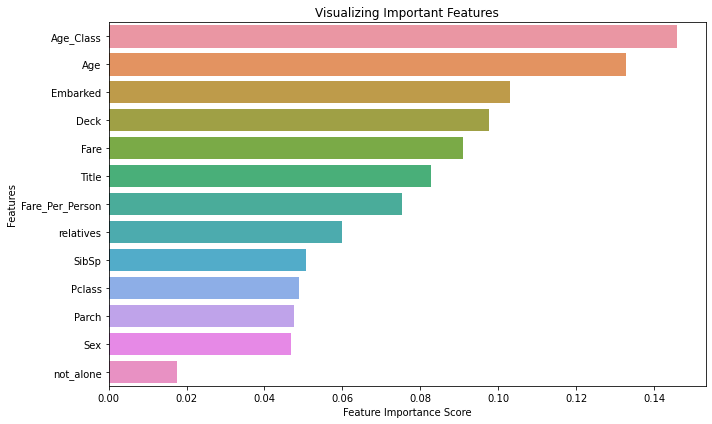

In [1]:
# https://towardsdatascience.com/predicting-the-survival-of-titanic-passengers-30870ccc7e8
# https://medium.com/analytics-vidhya/random-forest-on-titanic-dataset-88327a014b4d

# importing necessary libraries
from azureml.core import Workspace, Datastore, Dataset, Experiment, Model
from azureml.data.dataset_factory import DataType

# importing sklearn libraries
import sklearn
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

# Useful for good split of data into train and test
from sklearn.model_selection import train_test_split

# import pandas
import pandas as pd

# linear algebra
import numpy as np

# import re package
import re

# import joblib
import joblib

# import seaborn
import seaborn as sns

# import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt

# get existing workspace
ws = Workspace.from_config()

# set connection string settings
subscription_id = 'xxxxxxxx-xxxxxxx-xxxx-xxx-xxxxxxxxx'
resource_group = 'rg-machinelearning'
workspace_name = 'machinelearning'

# provide credential information
blob_datastore_name='machinelearnin9764837687' # Name of the datastore to workspace
container_name=os.getenv("BLOB_CONTAINER", "azureml-blobstore-xxxxxx-xxxx-xxxx-xxxx-xxxxxxxxxxxxx") # Name of Azure blob container
account_name=os.getenv("BLOB_ACCOUNTNAME", "machinelearninxxxxxxxxxxxx") # Storage account name
account_key=os.getenv("BLOB_ACCOUNT_KEY", "xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx") # Storage account access key

# register blob storage account within AMLS
datastore = Datastore.register_azure_blob_container(workspace=ws, 
                                                         datastore_name=blob_datastore_name, 
                                                         container_name=container_name, 
                                                         account_name=account_name,
                                                         account_key=account_key,
                                                         overwrite=True)

# connect to the azure blob storage account
try:
    datastore = Datastore.get(ws, blob_datastore_name)
    print("Found Blob Datastore with name: %s" % blob_datastore_name)
except UserErrorException:
    datastore = Datastore.register_azure_blob_container(
        workspace=ws,
        datastore_name=blob_datastore_name,
        account_name=account_name, # Storage account name
        container_name=container_name, # Name of Azure blob container
        account_key=account_key,
        protocol=http) # Storage account key
    print("Registered blob datastore with name: %s" % blob_datastore_name)

# download all files in local "download" folder
#ds.download(target_path='download', overwrite=True, show_progress=True)

# attach Titanic.csv file
dataset = Dataset.Tabular.from_delimited_files(path=[(datastore, 'Titanic.csv')])

# register Dataset as version 1
print("Register dataset in Azure ML")
dataset.register(workspace = ws, name = 'titanic', create_new_version = True)

# log experiment
print("Register experiment in Azure ML")
experiment = Experiment(ws, "TitanicExperiment")
run = experiment.start_logging(outputs=None, snapshot_directory=".")

# convert dataset to pandas dataframe
titanic_ds = dataset.to_pandas_dataframe()

print("Examine titanic dataset")
titanic_ds.info()

print("Show first records")
titanic_ds.head(10)

# convert ‘Sex’ feature into numeric
genders = {"male": 0, "female": 1}
data = [titanic_ds]
for dataset in data:
    dataset['Sex'] = dataset['Sex'].map(genders)

# since the most common port is Southampton the chances are that the missing one is from there
titanic_ds['Embarked'].fillna(value='S', inplace=True)

# convert ‘Embarked’ feature into numeric
ports = {"S": 0, "C": 1, "Q": 2}
data = [titanic_ds]
for dataset in data:
    dataset['Embarked'] = dataset['Embarked'].map(ports)

# convert ‘Survived’ feature into numeric
ports = {False: 0, True: 1}
data = [titanic_ds]
for dataset in data:
    dataset['Survived'] = dataset['Survived'].map(ports)

# a cabin number looks like ‘C123’ and the letter refers to the deck.
# therefore we’re going to extract these and create a new feature, that contains a persons deck. 
deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}
data = [titanic_ds]
for dataset in data:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)

# drop cabin since we have a deck feature
titanic_ds = titanic_ds.drop(['Cabin'], axis=1)

# fix age features missing values
data = [titanic_ds]
for dataset in data:
    mean = titanic_ds["Age"].mean()
    std = titanic_ds["Age"].std()
    is_null = dataset["Age"].isnull().sum()
    # compute random numbers between the mean, std and is_null
    rand_age = np.random.randint(mean - std, mean + std, size = is_null)
    # fill NaN values in Age column with random values generated
    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = rand_age
    dataset["Age"] = age_slice
    dataset["Age"] = titanic_ds["Age"].astype(int)

# convert ‘age’ to a feature holding a category
data = [titanic_ds]
for dataset in data:
    dataset['Age'] = dataset['Age'].astype(int)
    dataset.loc[ dataset['Age'] <= 11, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 11) & (dataset['Age'] <= 18), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 18) & (dataset['Age'] <= 22), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 22) & (dataset['Age'] <= 27), 'Age'] = 3
    dataset.loc[(dataset['Age'] > 27) & (dataset['Age'] <= 33), 'Age'] = 4
    dataset.loc[(dataset['Age'] > 33) & (dataset['Age'] <= 40), 'Age'] = 5
    dataset.loc[(dataset['Age'] > 40) & (dataset['Age'] <= 66), 'Age'] = 6
    dataset.loc[ dataset['Age'] > 66, 'Age'] = 6

# create titles
data = [titanic_ds]
titles = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}

for dataset in data:
    # extract titles
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)
    # replace titles with a more common title or as Rare
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr',\
                                            'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')
    # convert titles into numbers
    dataset['Title'] = dataset['Title'].map(titles)
    # filling NaN with 0, to get safe
    dataset['Title'] = dataset['Title'].fillna(0)

# drop name and title column since we have create a title
titanic_ds = titanic_ds.drop(['Name','Ticket'], axis=1)

# default missing fare rates
titanic_ds['Fare'].fillna(value=titanic_ds.Fare.mean(), inplace=True)

# convert fare to a feature holding a category
data = [titanic_ds]
for dataset in data:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[(dataset['Fare'] > 31) & (dataset['Fare'] <= 99), 'Fare']   = 3
    dataset.loc[(dataset['Fare'] > 99) & (dataset['Fare'] <= 250), 'Fare']   = 4
    dataset.loc[ dataset['Fare'] > 250, 'Fare'] = 5
    dataset['Fare'] = dataset['Fare'].astype(int)

# create not_alone and relatives features
data = [titanic_ds]
for dataset in data:
    dataset['relatives'] = dataset['SibSp'] + dataset['Parch']
    dataset.loc[dataset['relatives'] > 0, 'not_alone'] = 0
    dataset.loc[dataset['relatives'] == 0, 'not_alone'] = 1
    dataset['not_alone'] = dataset['not_alone'].astype(int)

# create age class
data = [titanic_ds]
for dataset in data:
    dataset['Age_Class']= dataset['Age']* dataset['Pclass']

# create fare per person
data = [titanic_ds]
for dataset in data:
    dataset['Fare_Per_Person'] = dataset['Fare']/(dataset['relatives']+1)
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

# convert all data to numbers
le = preprocessing.LabelEncoder()
titanic_ds=titanic_ds.apply(le.fit_transform)

print("Show first records of all the features created")
titanic_ds.head(10)

# convert all data to numbers
le = preprocessing.LabelEncoder()
titanic_ds=titanic_ds.apply(le.fit_transform)

# split our data into a test (30%) and train (70%) dataset
test_data_split = 0.30
msk = np.random.rand(len(titanic_ds)) < test_data_split 
test = titanic_ds[msk]
train = titanic_ds[~msk]

# drop ‘PassengerId’ from the train set, because it does not contribute to a persons survival probability
train = train.drop(['PassengerId'], axis=1)

# train_test_split is a function to split the dataset X (inputs) and y (output) into X_train,X_test,y_train,y_test respectively.
# shows 0.2 for testing data, therefore 0.8 for training data. shuffle=True means shuffling data.
# X_train - This includes your all independent variables,these will be used to train the model, also as we have specified the test_size = 0.4, this means 60% of observations from your complete data will be used to train/fit the model and rest 40% will be used to test the model.
# X_test - This is remaining 40% portion of the independent variables from the data which will not be used in the training phase and will be used to make predictions to test the accuracy of the model.
# Y_train - This is your dependent variable which needs to be predicted by this model, this includes category labels against your independent variables, we need to specify our dependent variable while training/fitting the model.
# Y_test - This data has category labels for your test data, these labels will be used to test the accuracy between actual and predicted categories.
X_train, X_test, Y_train, Y_test = train_test_split(train.drop("Survived", axis=1), train["Survived"],test_size=0.4,random_state=54,shuffle=True)

# show how the data is distributed
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)

print(X_train)
print(Y_train)

print("Show records of X_train dataset")
X_train.head(10)

# save data
np.savetxt('download/train.csv', train, delimiter=',')
np.savetxt('download/test.csv', test, delimiter=',')
np.savetxt('download/X_train.csv', X_train, delimiter=',')
np.savetxt('download/Y_train.csv', X_train, delimiter=',')
np.savetxt('download/X_test.csv', X_train, delimiter=',')
np.savetxt('download/Y_test.csv', X_train, delimiter=',')

# upload data to blob storage account
datastore.upload_files(files=['download/train.csv', 'download/test.csv', 'download/X_train.csv', 'download/Y_train.csv', 'download/X_test.csv', 'download/Y_test.csv'],
                       target_path='titanic_data/',
                       overwrite=True)

# attach all datasets
dataset_train = Dataset.Tabular.from_delimited_files(path=[(datastore, 'titanic_data/train.csv')])
dataset_test = Dataset.Tabular.from_delimited_files(path=[(datastore, 'titanic_data/test.csv')])
dataset_X_train = Dataset.Tabular.from_delimited_files(path=[(datastore, 'titanic_data/X_train.csv')])
dataset_Y_train = Dataset.Tabular.from_delimited_files(path=[(datastore, 'titanic_data/Y_train.csv')])
dataset_X_test = Dataset.Tabular.from_delimited_files(path=[(datastore, 'titanic_data/X_test.csv')])
dataset_Y_test= Dataset.Tabular.from_delimited_files(path=[(datastore, 'titanic_data/Y_test.csv')])

# register datasets as version 1
dataset_train.register(workspace = ws, name = 'train', create_new_version = True)
dataset_test.register(workspace = ws, name = 'test', create_new_version = True)
dataset_X_train.register(workspace = ws, name = 'X_train', create_new_version = True)
dataset_Y_train.register(workspace = ws, name = 'Y_train', create_new_version = True)
dataset_X_test.register(workspace = ws, name = 'X_test', create_new_version = True)
dataset_Y_test.register(workspace = ws, name = 'Y_test', create_new_version = True)

# Random Forest
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)

# Save model as pickle file
joblib.dump(random_forest, "outputs/random_forest.pkl")

# Predict and get result
Y_prediction = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)

# show the important features for the classification
feature_imp = pd.Series(random_forest.feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.tight_layout()

# log plot image
run.log_image('Feature Importance Score', plot=plt)

# register model within workspace
model_random_forest = Model.register(workspace=ws,
                       model_name='random_forest',
                       model_path='outputs/random_forest.pkl',
                       model_framework=Model.Framework.SCIKITLEARN,
                       model_framework_version=sklearn.__version__,
                       sample_input_dataset=dataset_X_train,
                       sample_output_dataset=dataset_Y_train,
                       description='Titanic survival prediction using random forest.',
                       datasets = [('train',dataset_train),('test',dataset_test),('X_train',dataset_X_train),('Y_train',dataset_Y_train),('X_test',dataset_X_test),('Y_test',dataset_Y_test)],
                       tags={'type': 'regression'})


# create result table showing the outcome of all models
results = pd.DataFrame({
    'Model': ['Random Forest'],
    'Score': [acc_random_forest]})
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Score')

#complete run
run.log("Random Forest accuracy", acc_random_forest)
run.complete()

# show results of outcome table
result_df.head(9)